# Clusterless Decoding of Position from Hippocampal Spike Trains
### Data Collected by Smear Lab, University of Oregon
### Code by Sid Rafilson, University of Oregon

In [1]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from scipy.io import loadmat
from scipy.interpolate import interp1d

from matplotlib.colors import LogNorm

from replay_trajectory_classification import ClusterlessDecoder, Environment, RandomWalk, estimate_movement_var

sns.set_context('notebook', font_scale=1.5)

# Set up logging
logging.basicConfig(level=logging.INFO)

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """
    return np.isnan(y), lambda z: z.nonzero()[0]

def cv_split(data, k, k_CV=2, n_blocks=10):
    '''
    Perform an 80/20 cross-validation split of the data, following the Hardcastle et 
    al paper.
    
    Parameters
    --
    data : An array of data.
    
    k : Which CV subset to hold out as testing data (integer from 0 to k_CV-1).
    
    k_CV : Number of CV splits (integer).
        
    n_blocks : Number of blocks for initially partitioning the data. The testing
        data will consist of a fraction 1/k_CV of the data from each of these
        blocks.
        
    Returns
    --
    data_train, data_test : Data arrays after performing the train/test split.
    '''

    block_size = len(data)//n_blocks
    mask_test = [False for _ in data]
    for block in range(n_blocks):
        i_start = int((block + k/k_CV)*block_size)
        i_stop = int(i_start + block_size//k_CV)
        mask_test[i_start:i_stop] = [True for _ in range(block_size//k_CV)]
    mask_train = [not a for a in mask_test]
    data_test = data[mask_test]
    data_train = data[mask_train]

    return data_train, data_test

def half_split(data):
    """
    Split the dataset into two halves for training and testing.
    
    Parameters
    --
    data : An array or list of data.
    
    Returns
    --
    data_train, data_test : Data arrays after performing the 50/50 split.
    """
    midpoint = len(data) // 2
    data_train = data[:midpoint]
    data_test = data[midpoint:]
    return data_train, data_test


e:\ClusterlessDecoding\venv\lib\site-packages\replay_trajectory_classification\likelihoods\multiunit_likelihood.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Loading in the data from one session. The multiunit activty is sampled at 30KHz and the tracking data is sampled at 1KHz.

In [2]:
mouse = 4133
session = 2

MUA_file = f"E:\\PlaceCells\\{mouse}\\{session}\\MUA.npy"
track_file = f"E:\\PlaceCells\\{mouse}\\{session}\\track.mat"
timestamps_file = f"E:\\PlaceCells\\{mouse}\\{session}\\gpio_locs.mat"
channel_map_file = f"E:\\PlaceCells\\{mouse}\\{session}\\channel_map.npy"
channel_positions_file = f"E:\\PlaceCells\\{mouse}\\{session}\\channel_positions.npy"


# Load the MUA data
MUA = np.load(MUA_file).astype(np.int16)
logging.info(f"Loaded multiunit activty data with shape {MUA.shape}")

# Load the track data
tracking = loadmat(track_file)['track']
logging.info(f"Loaded tracking data with shape {tracking.shape}")

# Load the timestamps
timestamps = loadmat(timestamps_file)['gpio_locs'].squeeze()
logging.info(f"Loaded timestamps data with shape {timestamps.shape}")

# Load the channel map
channel_map = np.load(channel_map_file).flatten()
logging.info(f"Loaded channel map with shape {channel_map.shape}")

# Load the channel positions
channel_positions = np.load(channel_positions_file)
logging.info(f"Loaded channel positions with shape {channel_positions.shape}")






INFO:root:Loaded multiunit activty data with shape (32, 55296000)
INFO:root:Loaded tracking data with shape (184255, 7)
INFO:root:Loaded timestamps data with shape (184255,)
INFO:root:Loaded channel map with shape (32,)
INFO:root:Loaded channel positions with shape (32, 2)


We now use the channel map and channel positions to sort the rows of the multiunit activity matrix into the tetrodes they came from.

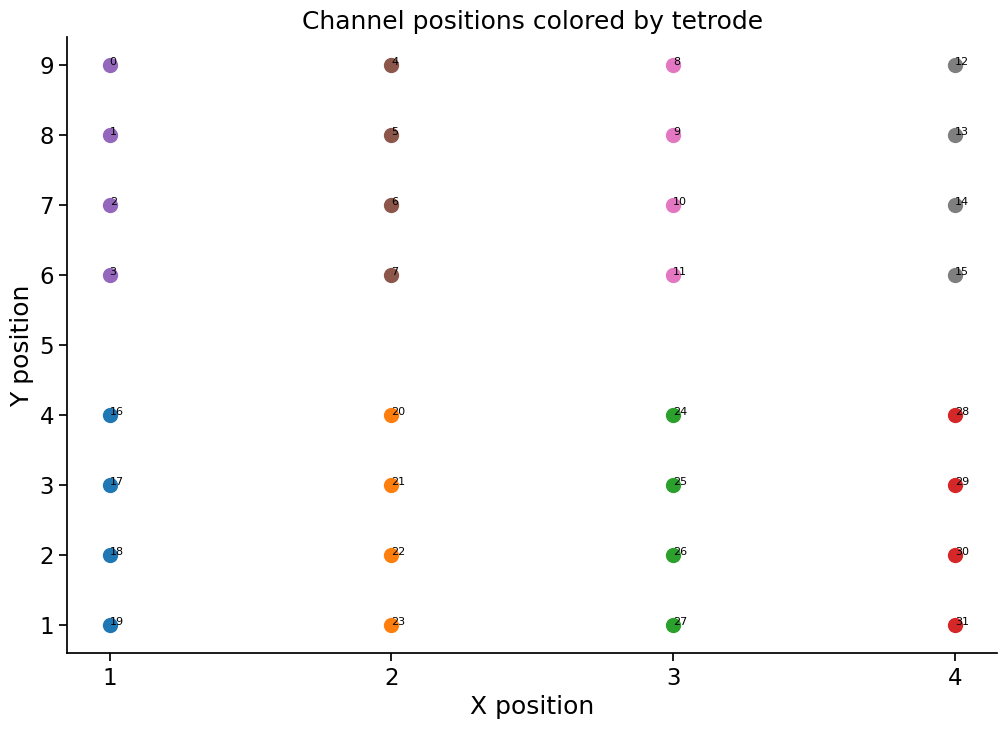

In [3]:
# Initialize tetrode map

tetrode_map = np.zeros_like(channel_map)

# Assign tetrode numbers based on the positions
for i, (x, y) in enumerate(channel_positions.astype(int)):
    if x == 1 and y in [1, 2, 3, 4]:
        tetrode_map[i] = 0
    elif x == 2 and y in [1, 2, 3, 4]:
        tetrode_map[i] = 1
    elif x == 3 and y in [1, 2, 3, 4]:
        tetrode_map[i] = 2
    elif x == 4 and y in [1, 2, 3, 4]:
        tetrode_map[i] = 3
    elif x == 1 and y in [6, 7, 8, 9]:
        tetrode_map[i] = 4
    elif x == 2 and y in [6, 7, 8, 9]:
        tetrode_map[i] = 5
    elif x == 3 and y in [6, 7, 8, 9]:
        tetrode_map[i] = 6
    elif x == 4 and y in [6, 7, 8, 9]:
        tetrode_map[i] = 7
    else:
        print('channel map error')
  

    
# plotting channel positions as dots colored by tetrode in tab10

plt.figure(figsize=(12, 8))
for i, (x, y) in enumerate(channel_positions):
    plt.scatter(x, y, color = plt.cm.tab10(tetrode_map[i]), s=100)
    plt.text(x, y, str(channel_map[i]), fontsize=8)
plt.xticks(np.arange(1, 4.5, 1))
plt.xlabel("X position")
plt.ylabel("Y position")
sns.despine()
plt.title("Channel positions colored by tetrode")
plt.show()

    
  


We can now plot a few seconds of multiunit activty frrom each channel and color code the spikes by the tetrode they came from.

In [4]:
# Common average median reference to remove noise
MUA = MUA - np.median(MUA, axis=0)

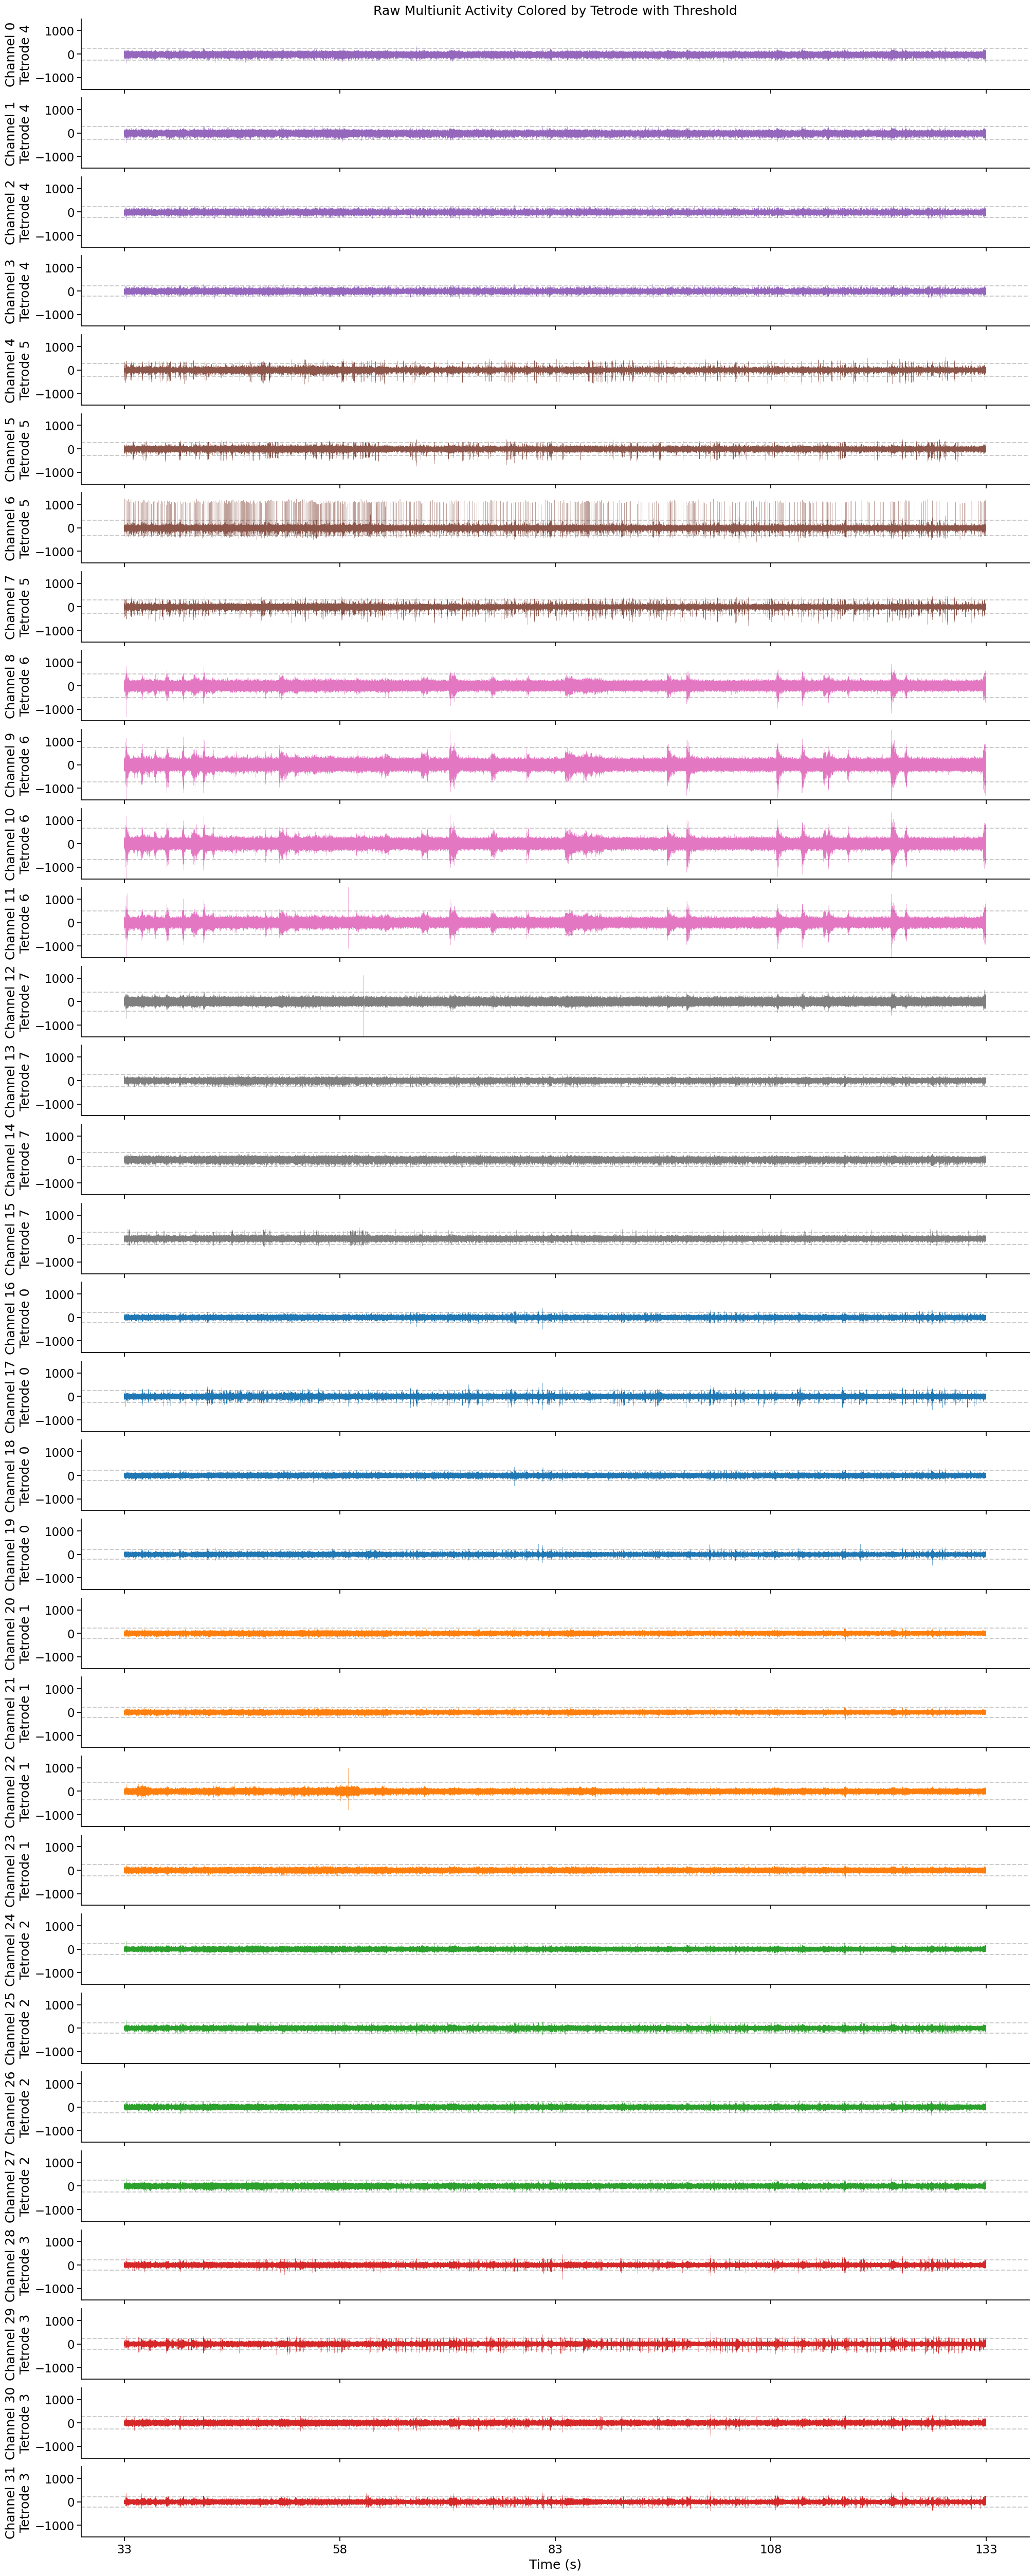

In [5]:
# define constants for plotting
fs = 30_000
start = 1_000_000
stop = 4_000_000
threshold = 7
time_ticks = np.linspace(0, stop - start, 5)
time_labels = np.linspace(start // fs, stop // fs, 5)
channel_thresholds = np.std(MUA[channel_map], axis=1) * threshold

# Plot the raw multiunit activity data
fig, axes = plt.subplots(channel_map.shape[0], 1, figsize=(20, 50), sharex=True, constrained_layout=True)
for i, ax in enumerate(axes):
    current_data = MUA[channel_map[i], start:stop]
    current_threshold = channel_thresholds[i]
    ax.plot(current_data, color=plt.cm.tab10(tetrode_map[i]), linewidth=0.2)
    ax.axhline(current_threshold, color='black', linestyle='--', alpha=0.2)
    ax.axhline(-current_threshold, color='black', linestyle='--', alpha=0.2)
    ax.set_ylabel(f"Channel {channel_map[i]}\nTetrode {tetrode_map[i]}")
    ax.set_ylim(-1500, 1500)

sns.despine()
axes[-1].set_xticks(time_ticks)
axes[-1].set_xticklabels([f"{int(tick)}" for tick in time_labels])
axes[-1].set_xlabel("Time (s)")
axes[0].set_title("Raw Multiunit Activity Colored by Tetrode with Threshold")

# Show plot
plt.show()

Extracting the head position and timestamps from the tracking data

In [6]:
head =  tracking[:,3:5]
frame_times_ds = tracking[:,0]  # frame times in ms (one frame per ~10ms)
frame_times = frame_times_ds * 30  # convert to 30kHz clock
frame_times_seconds = frame_times_ds / 1000  # convert to seconds



In [7]:


for i in range(2):
    nans, x = nan_helper(head[:,i])
    if np.sum(nans) > 0:
        head[nans, i] = np.interp(x(nans), x(~nans), head[~nans, i])

# The box boundaries for spatial tracking (see readme file):
x_min, x_max = 0, 1200
y_min, y_max = 0, 500

# clip and normalize the head position
pos = np.zeros_like(head)
pos[:,0] = np.clip(head[:,0], np.percentile(head[:,0], 0.5), np.percentile(head[:,0], 99.5))
pos[:,1] = np.clip(head[:,1], np.percentile(head[:,1], 0.5), np.percentile(head[:,1], 99.5))
pos[:,0] -= np.min(pos[:,0])
pos[:,1] -= np.min(pos[:,1])
pos[:,0] = pos[:,0]*x_max/np.max(pos[:,0])
pos[:,1] = pos[:,1]*y_max/np.max(pos[:,1])










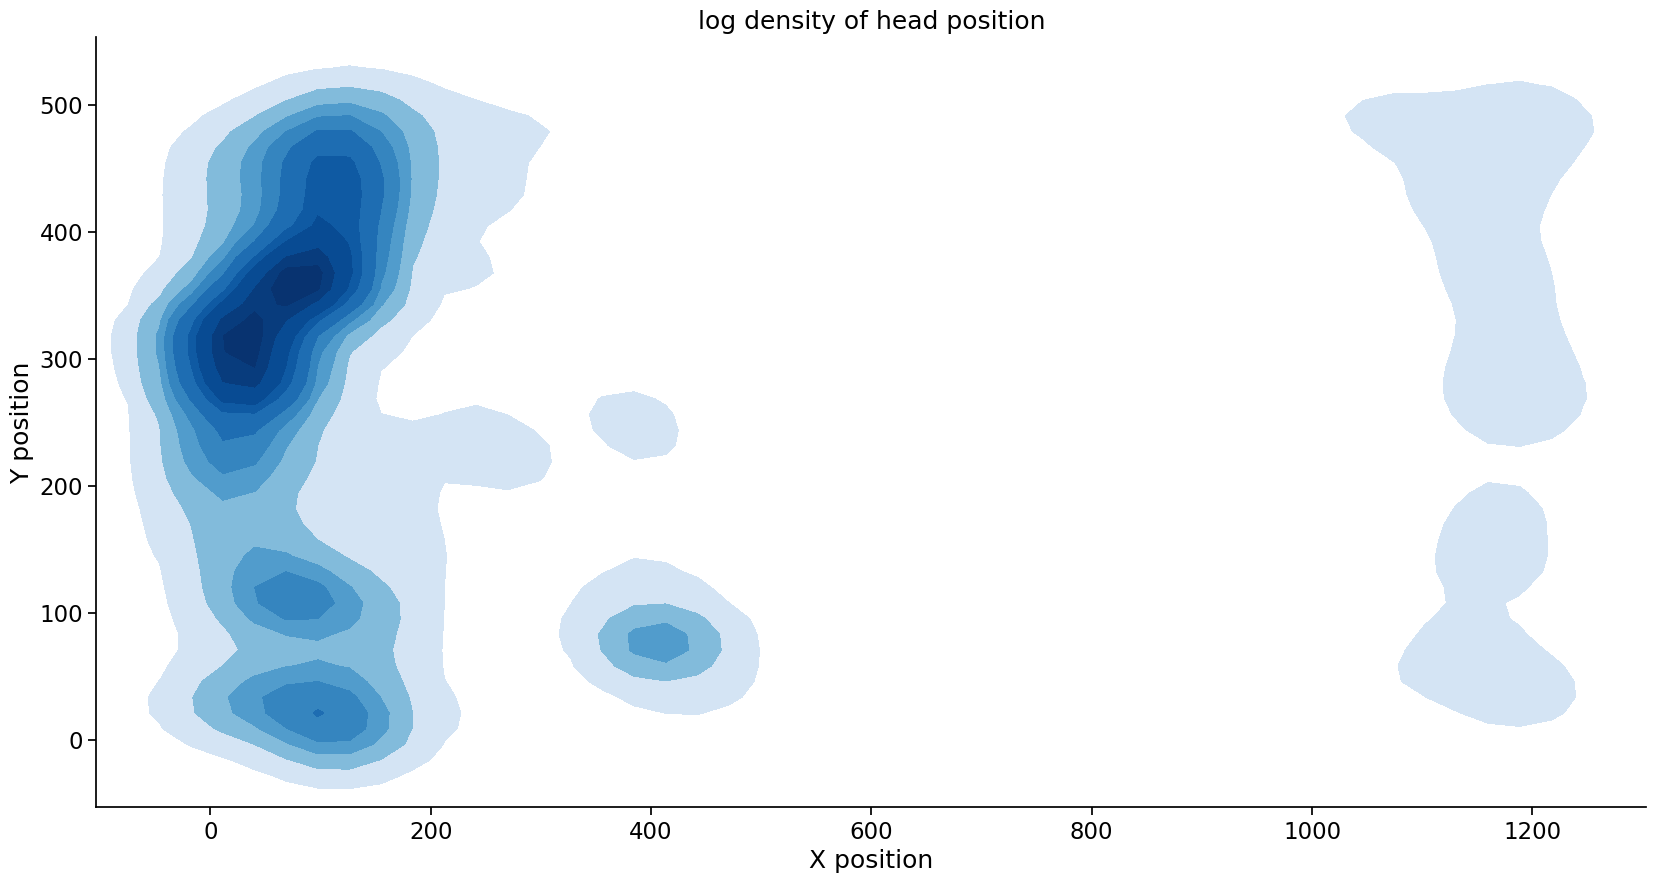

In [8]:
# plotting the head position as a heatmap
plt.figure(figsize=(20, 10))
sns.kdeplot(x = pos[:, 0], y = pos[:, 1], cmap='Blues', fill=True, gridsize=50, norm = LogNorm())
plt.xlabel("X position")
plt.ylabel("Y position")
sns.despine()

plt.title("log density of head position")
plt.show()




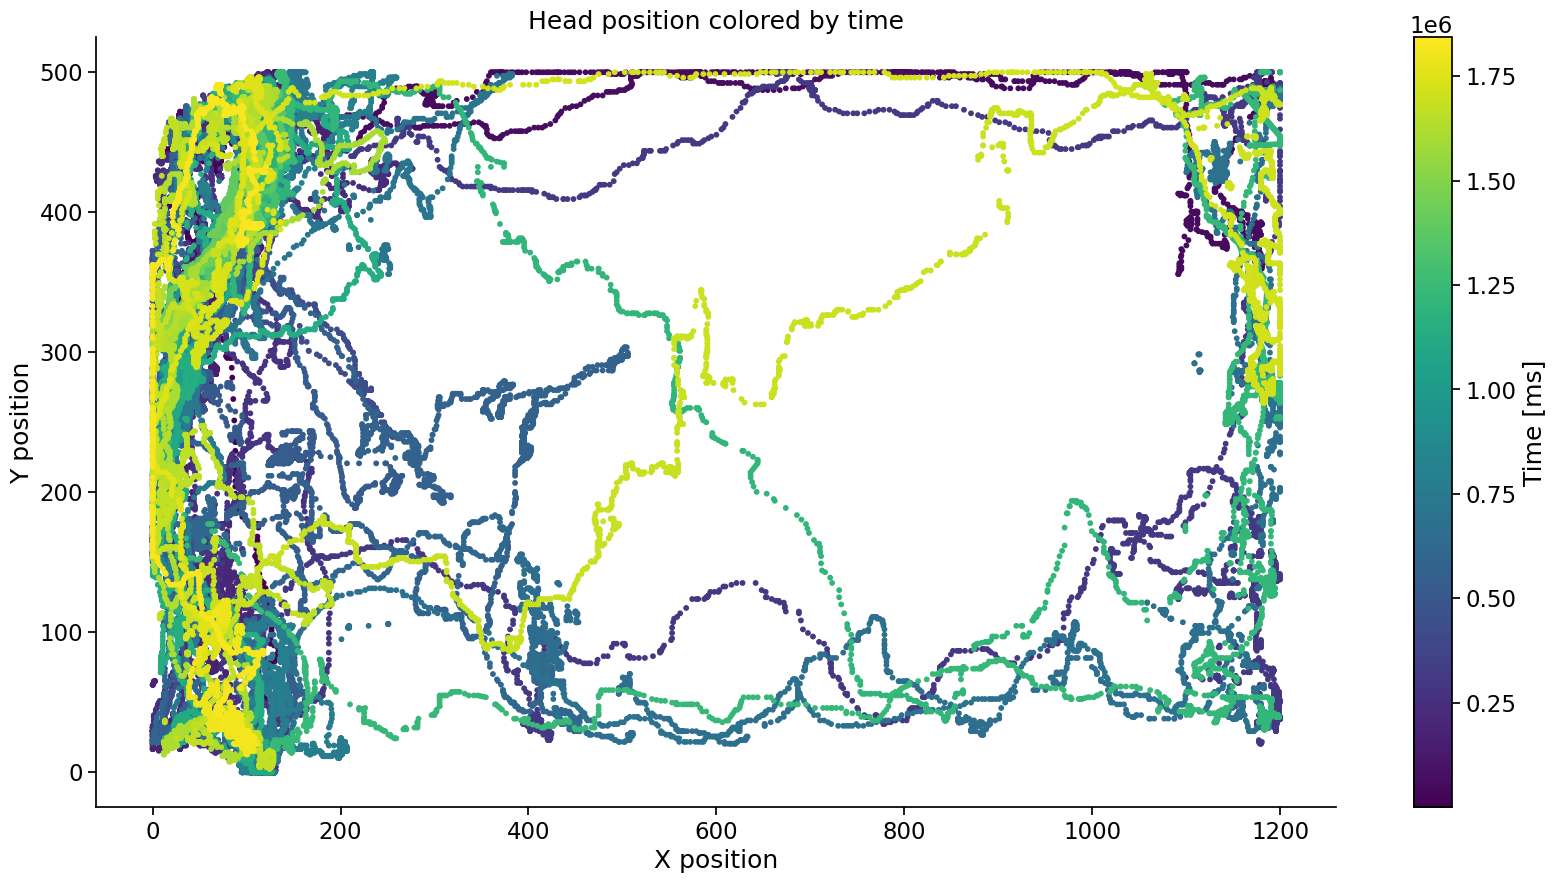

In [9]:
# Plotting the headposition with color to denote time
plt.figure(figsize=(20, 10))
plt.scatter(pos[:, 0], pos[:, 1], c=frame_times_ds, cmap='viridis', s=10)
plt.xlabel("X position")
plt.ylabel("Y position")
plt.colorbar(label="Time [ms]")
sns.despine()
plt.title("Head position colored by time")
plt.show()


Finding the spike times and marks for each tetrode

In [10]:
# Threshold calculation using non-noise channels
MUA_channels = MUA[channel_map]


# Constants
fs = 30_000  # Hz
threshold = 7  # number of standard deviations for threshold
time_window = int(5e-3 * fs)  # 5 ms window in samples
min_spike_interval = int(1e-3 * fs)  # Minimum 1 ms gap between spikes

# Function to detect spikes and extract maximum voltage in a time window
def detect_spikes(MUA, channel_map, tetrode_map, threshold_std, time_window, fs, min_spike_interval):
    '''
    Detect spikes in the MUA data and extract spike details.

    Parameters
    --
    MUA : Multiunit activity data (n_channels x n_samples)
    channel_map : Mapping of channel index to channel number
    tetrode_map : Mapping of channel index to tetrode number
    threshold : Threshold for spike detection
    time_window : Time window around the spike to extract (in samples)
    fs : Sampling frequency of the data
    min_spike_interval : Minimum interval between spikes (in samples)
    '''

    # Spike detection: Find where the absolute signal exceeds threshold
    threshold = np.std(MUA) * threshold_std
    spikes = np.abs(MUA) > threshold

    # Preallocate list to store spike details
    spike_details = []

    # Loop through each tetrode (4 channels per tetrode)
    for tetrode in np.unique(tetrode_map):
        # Get the channels belonging to the current tetrode
        tetrode_channels = [i for i, t in enumerate(tetrode_map) if t == tetrode]
        
        # Loop through each channel in the tetrode
        for ch in tetrode_channels:
            spike_times = np.where(spikes[ch])[0]
            grouped_spikes = []  # Store grouped spike times
            
            # Group consecutive spikes within the same threshold crossing
            current_spike = None
            for spike_time in spike_times:
                if current_spike is None:  # First spike
                    current_spike = spike_time
                elif spike_time - current_spike > min_spike_interval:  # New spike (too far apart)
                    grouped_spikes.append(current_spike)
                    current_spike = spike_time
            if current_spike is not None:  # Append the last spike
                grouped_spikes.append(current_spike)

            # Now process each grouped spike
            for spike_time in grouped_spikes:
                # Define window range
                start_idx = max(0, spike_time - time_window // 2)
                end_idx = min(MUA.shape[1], spike_time + time_window // 2)

                # Find maximum voltage for the spike time window
                max_voltage = np.max(np.abs(MUA[tetrode_channels, start_idx:end_idx]), axis=1)

                # Collect spike details
                spike_details.append({
                    "Spike_Time": spike_time,
                    "Channel": channel_map[ch],
                    "Tetrode": tetrode,
                    "Max_Voltage": max_voltage.tolist(),
                })

    # Convert the list of spike details to a DataFrame
    spike_data = pd.DataFrame(spike_details)

    # Convert spike times to seconds
    spike_data["Spike_Time_s"] = spike_data["Spike_Time"] / fs

    # Return the final dataframe
    return spike_data

# Detect spikes and extract features
spike_data = detect_spikes(MUA_channels, channel_map, tetrode_map, threshold, time_window, fs, min_spike_interval)

# Print results
logging.info(f"Found {len(spike_data)} spikes")
print(spike_data.head())

INFO:root:Found 204229 spikes


   Spike_Time  Channel  Tetrode                   Max_Voltage  Spike_Time_s
0      100419       16        0  [436.5, 262.5, 312.5, 212.0]      3.347300
1      243326       16        0  [326.5, 434.0, 153.5, 213.0]      8.110867
2      705635       16        0  [346.0, 309.0, 230.0, 164.0]     23.521167
3     2017752       16        0  [416.5, 377.5, 233.5, 230.5]     67.258400
4     2457288       16        0  [507.0, 565.5, 260.5, 394.5]     81.909600


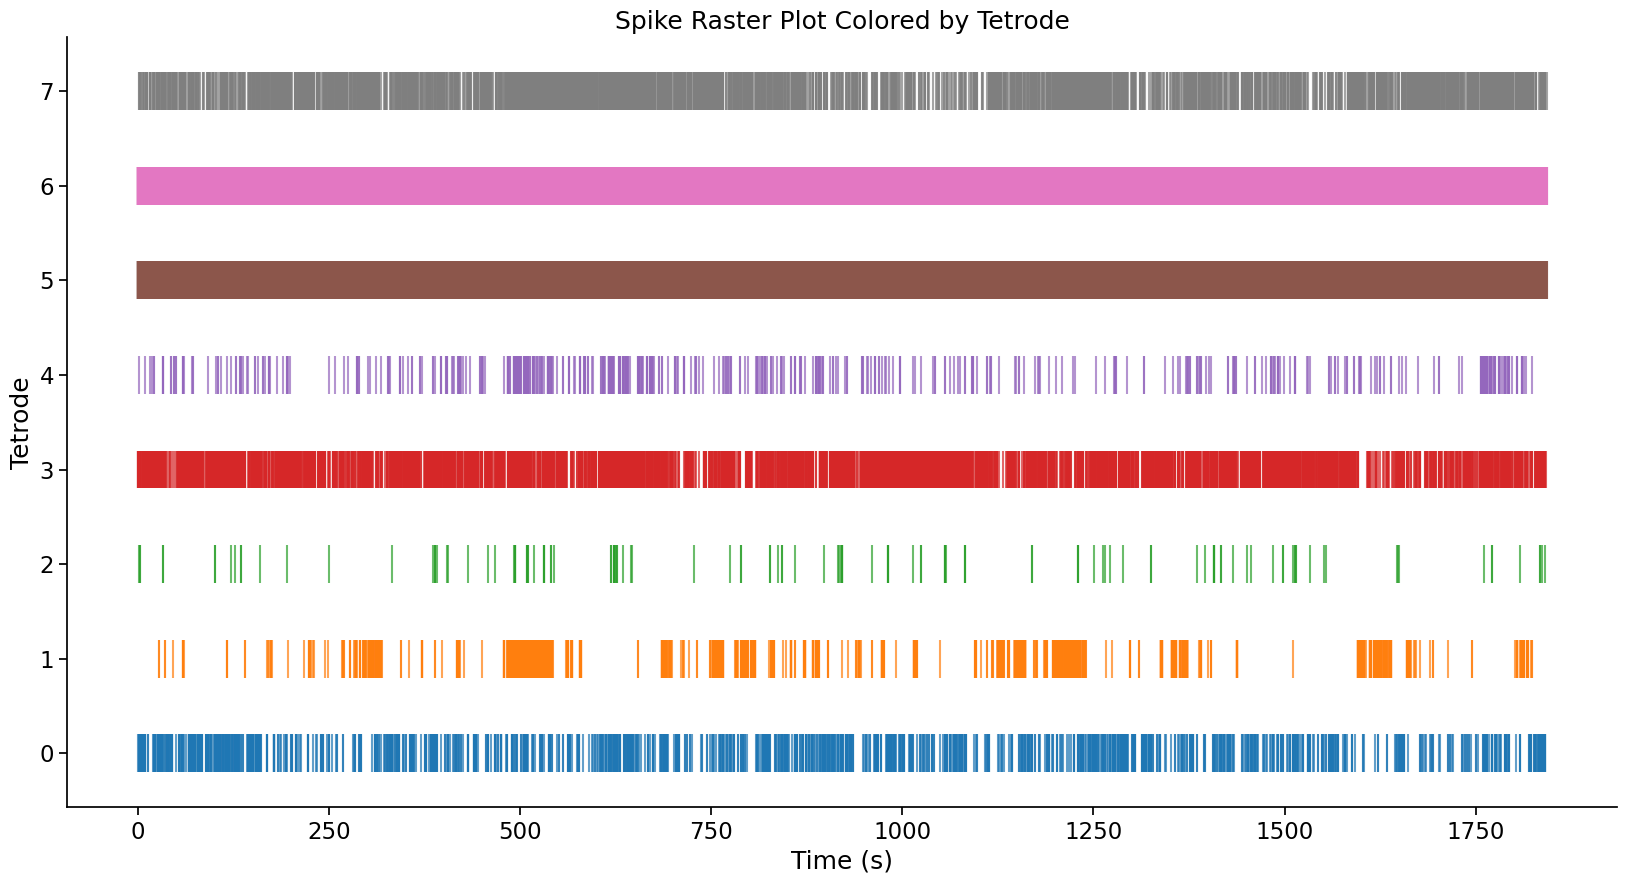

In [11]:
# Create the figure
plt.figure(figsize=(20, 10))

# Loop through each channel and plot the spikes as vertical lines
for _, row in spike_data.iterrows():
    plt.vlines(
        x=row["Spike_Time_s"],
        ymin=row["Tetrode"] - 0.1,  # Adjust for line thickness
        ymax=row["Tetrode"] + 0.1,
        color=plt.cm.tab10(row["Tetrode"]),
        alpha=0.7
    )

# Add labels and title
plt.ylabel("Tetrode")
plt.xlabel("Time (s)")
plt.title("Spike Raster Plot Colored by Tetrode")
sns.despine()
plt.show()



We can now build our mark matrix, and build our spike matrix

In [12]:
# Time array
time = np.arange(MUA_channels.shape[1]) / fs

# Number of unique tetrodes
n_tetrodes = len(np.unique(tetrode_map))

# Multiunit spikes array: shape (time, n_tetrodes), boolean
multiunit_spikes = np.zeros((MUA_channels.shape[1], n_tetrodes), dtype=bool)

# Assign spikes to multiunit_spikes based on spike data
for _, row in spike_data.iterrows():
    spike_time = int(row["Spike_Time"])
    tetrode = row["Tetrode"]
    multiunit_spikes[spike_time, tetrode] = True

# Interpolating position data
position = np.zeros((len(time), 2), dtype=np.int16)
position[:, 0] = interp1d(frame_times_seconds, pos[:, 0], fill_value='extrapolate')(time).astype(np.int16)
position[:, 1] = interp1d(frame_times_seconds, pos[:, 1], fill_value='extrapolate')(time).astype(np.int16)

# Creating multiunits array with shape (time, 4, tetrodes)
multiunits = np.full((MUA_channels.shape[1], 4, n_tetrodes), fill_value=np.nan, dtype=np.float32)

# Loop through each tetrode
for tetrode in range(n_tetrodes):
    # Get the channels for the current tetrode
    tetrode_channels = [idx for idx, t in enumerate(tetrode_map) if t == tetrode]

    for i, channel in enumerate(tetrode_channels):
        # Filter spike data for the current channel and tetrode
        tetrode_spikes = spike_data[spike_data["Tetrode"] == tetrode]

        # Loop through each spike time for this tetrode
        for _, row in tetrode_spikes.iterrows():
            spike_time = int(row["Spike_Time"])
            max_voltage = row["Max_Voltage"][i]  # Use precomputed max voltage

            # Update the multiunits array
            multiunits[spike_time, i, tetrode] = max_voltage


# Final multiunit arrays
print(f"multiunit_spikes shape: {multiunit_spikes.shape}")
print(f"multiunit_spikes dtype: {multiunit_spikes.dtype}")
print(f"position shape: {position.shape}")
print(f"position dtype: {position.dtype}")
print(f"multiunits shape: {multiunits.shape}")
print(f"multiunits dtype: {multiunits.dtype}")

# Display the first few rows for validation
first_spike_index = spike_data["Spike_Time"].values[0]

print(multiunits[first_spike_index - 2:first_spike_index + 2, :, 0])




multiunit_spikes shape: (55296000, 8)
multiunit_spikes dtype: bool
position shape: (55296000, 2)
position dtype: int16
multiunits shape: (55296000, 4, 8)
multiunits dtype: float32
[[  nan   nan   nan   nan]
 [  nan   nan   nan   nan]
 [436.5 262.5 312.5 212. ]
 [  nan   nan   nan   nan]]


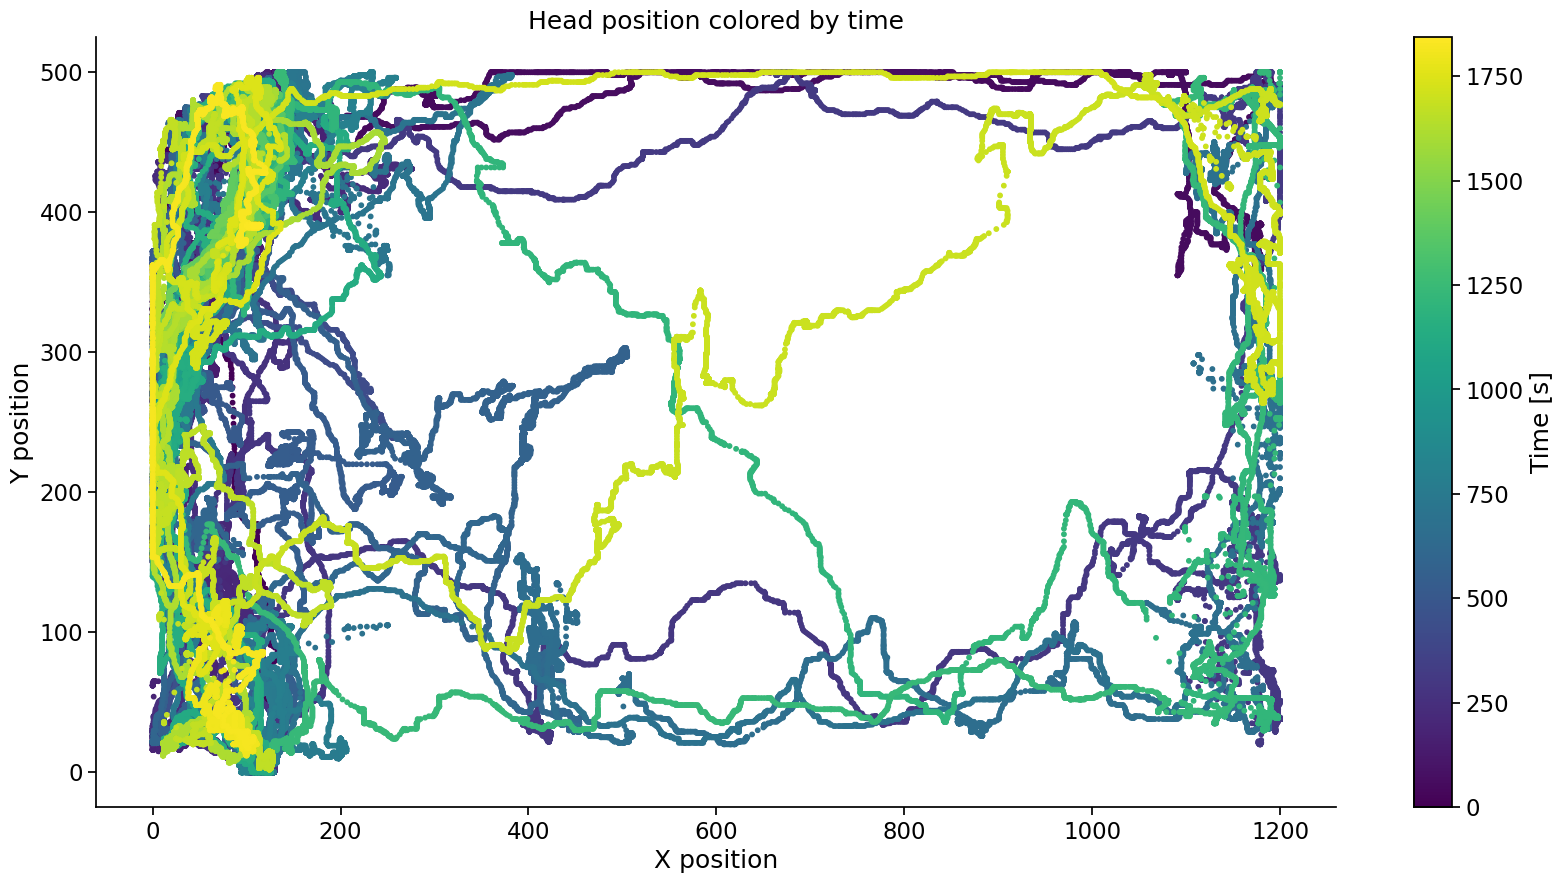

In [13]:
# plot a snail trail of every 100th position
plt.figure(figsize=(20, 10))
plt.scatter(position[::100, 0], position[::100, 1], c=time[::100], cmap='viridis', s=10)
plt.xlabel("X position")
plt.ylabel("Y position")
plt.colorbar(label="Time [s]")
sns.despine()
plt.title("Head position colored by time")
plt.show()




In [16]:
movement_var = estimate_movement_var(position, fs)
print(f'Movement covaraince {movement_var}')



environment = Environment(place_bin_size=50, position_range=[(0, 1200), (0, 500)])
transition_type = RandomWalk(movement_var=movement_var)

mark_std = 20.0
position_std = 20.0

clusterless_algorithm = 'multiunit_likelihood_integer_gpu_log'
clusterless_algorithm_params = {
    'mark_std': mark_std,
    'position_std': position_std
}

    

decoder = ClusterlessDecoder(
    environment=environment,
    transition_type=transition_type,
    clusterless_algorithm=clusterless_algorithm,
    clusterless_algorithm_params=clusterless_algorithm_params)



decoder

Movement covaraince [[42.22873417 -0.31629775]
 [-0.31629775 41.30805154]]


ClusterlessDecoder(clusterless_algorithm='multiunit_likelihood_integer_gpu_log',
                   clusterless_algorithm_params={'mark_std': 20.0,
                                                 'position_std': 20.0},
                   environment=Environment(environment_name='',
                                           place_bin_size=50,
                                           track_graph=None,
                                           edge_order=None,
                                           edge_spacing=None,
                                           is_track_interior=None,
                                           position_range=[(0, 1200), (0, 500)],
                                           infer_track_interior=True,
                                           fill_holes=False,
                                           dilate=False,
                                           bin_count_threshold=0),
                   infer_track_interior=True,
                   initial_conditions_type=UniformInitialConditions(),
                   transition_type=RandomWalk(environment_name='',
                                              movement_var=array([[42.22873417, -0.31629775],
       [-0.31629775, 41.30805154]]),
                                              movement_mean=0.0,
                                              use_diffusion=False))

In [17]:
# Split the data into training and testing sets with a 50/50 split
position_train, position_test = half_split(position)
multiunits_train, multiunits_test = half_split(multiunits)
multiunit_spikes_train, multiunit_spikes_test = half_split(multiunit_spikes)
time_train, time_test = half_split(time)

In [ ]:


# Splitting the data into training and testing sets with 80/20 cross-validation
position_train, position_test = cv_split(position, 0, 2, 10)
multiunits_train, multiunits_test = cv_split(multiunits, 0, 2, 10)
multiunit_spikes_train, multiunit_spikes_test = cv_split(multiunit_spikes, 0, 2, 10)
time_train, time_test = cv_split(time, 0, 2, 10)



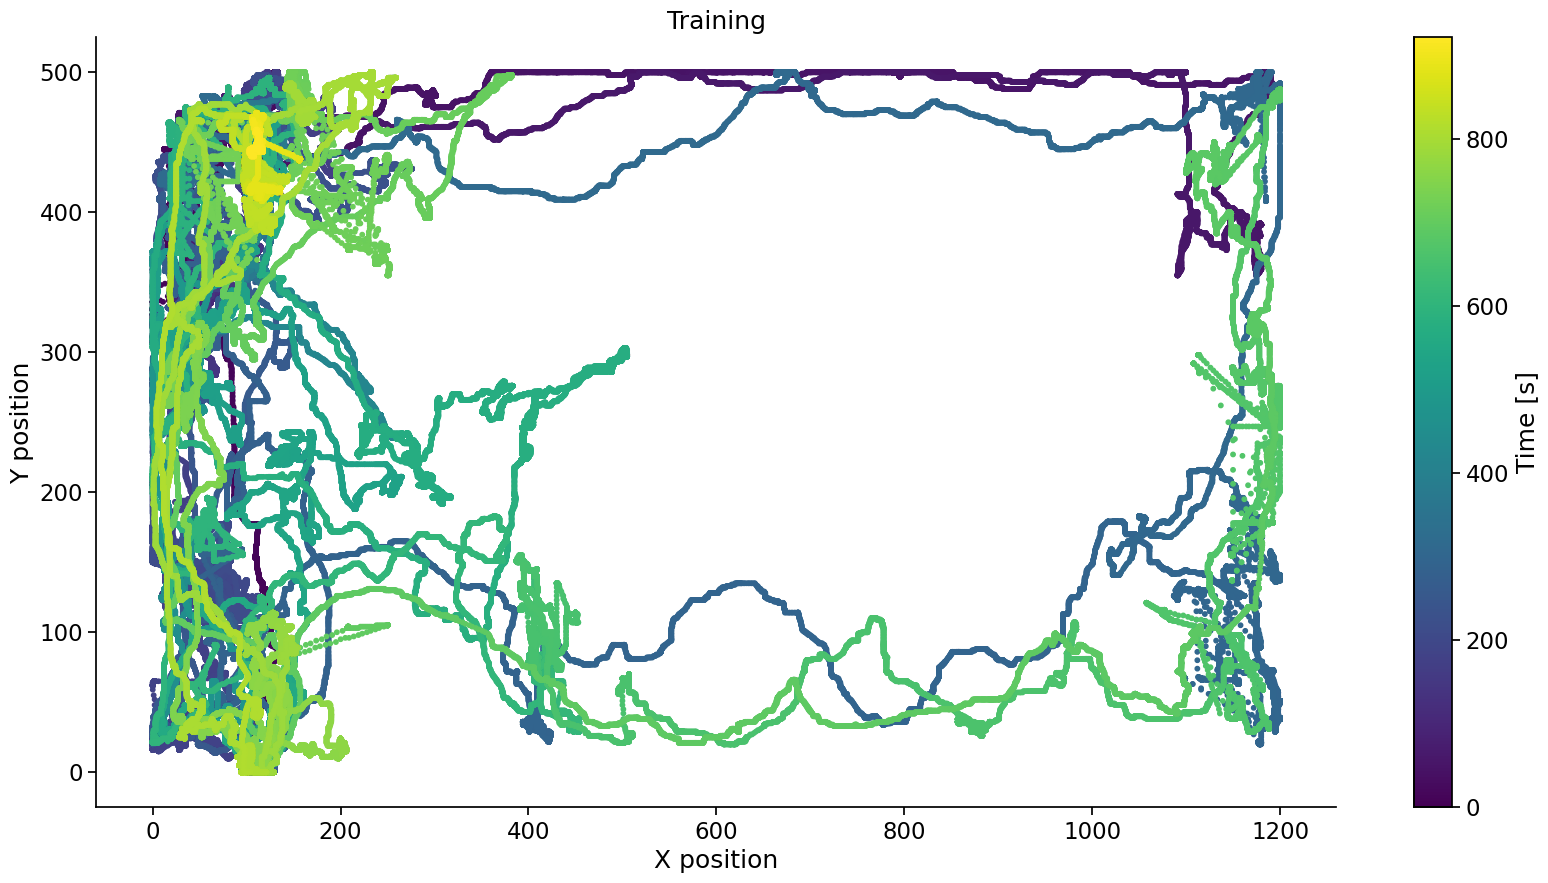

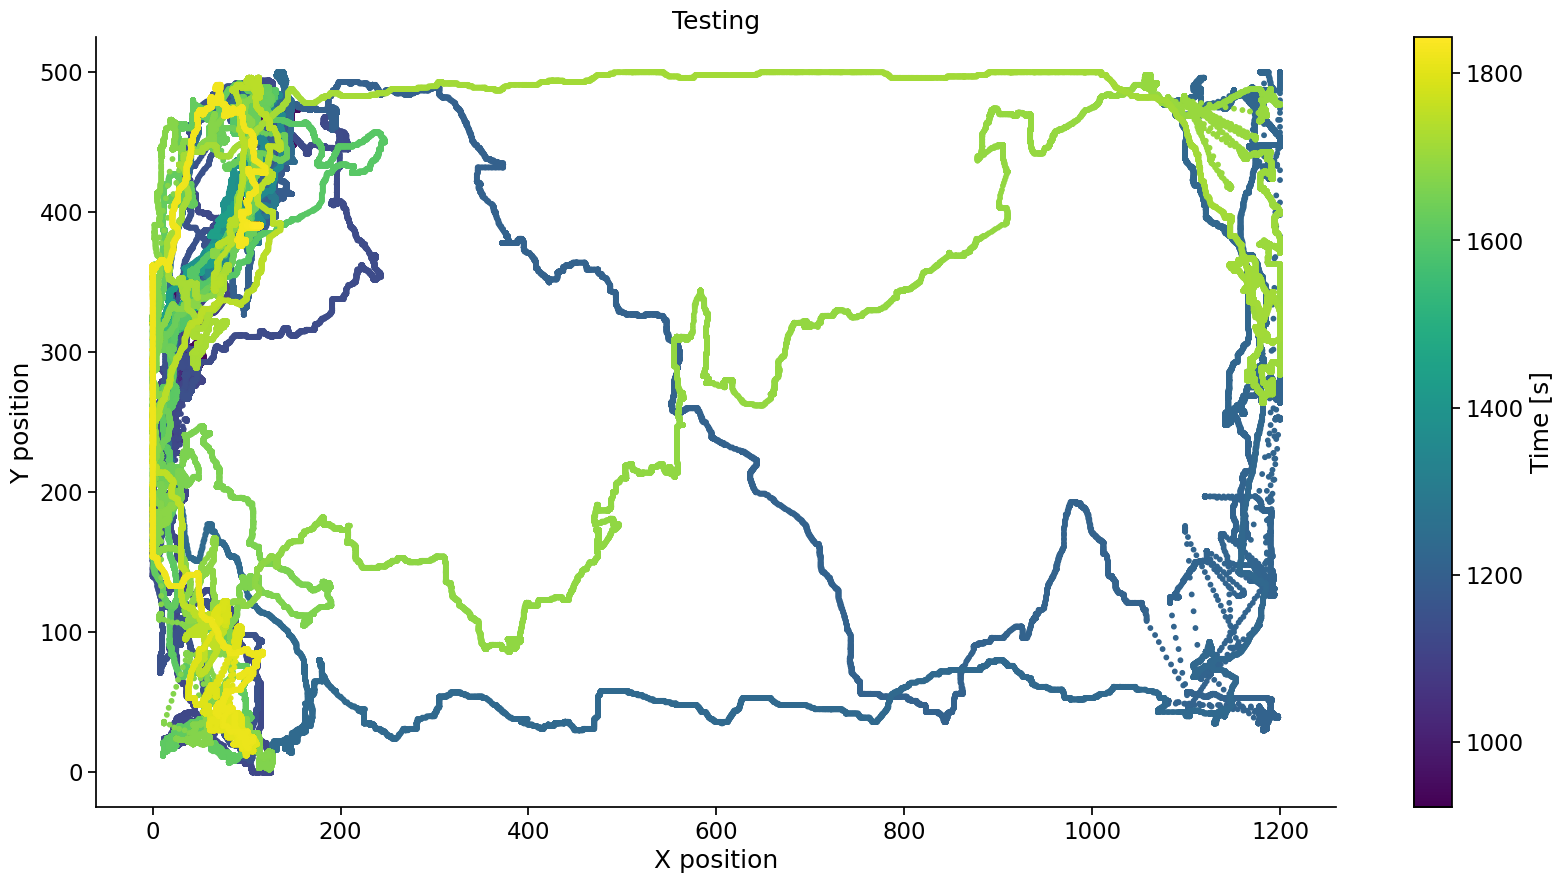

In [18]:


# plotting the position data (training)
plt.figure(figsize=(20, 10))
plt.scatter(position_train[::30, 0], position_train[::30, 1], c=time_train[::30], cmap='viridis', s=10)
plt.xlabel("X position")
plt.ylabel("Y position")
plt.colorbar(label="Time [s]")
sns.despine()
plt.title("Training")
plt.show()

# plotting the position data (testing)
plt.figure(figsize=(20, 10))
plt.scatter(position_test[::30, 0], position_test[::30, 1], c=time_test[::30], cmap='viridis', s=10)
plt.xlabel("X position")
plt.ylabel("Y position")
plt.colorbar(label="Time [s]")
sns.despine()
plt.title("Testing")
plt.show()






In [19]:
# deleting unnecessary variables
del MUA, MUA_channels, channel_map, channel_positions, tetrode_map, tracking, timestamps, spike_data, multiunits, multiunit_spikes

In [20]:

decoder.fit(position_train, multiunits_train)


INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
e:\ClusterlessDecoding\venv\lib\site-packages\replay_trajectory_classification\continuous_state_transitions.py:26: RuntimeWarning: invalid value encountered in divide
  x /= x.sum(axis=1, keepdims=True)
INFO:replay_trajectory_classification.decoder:Fitting multiunits...


ClusterlessDecoder(clusterless_algorithm='multiunit_likelihood_integer_gpu_log',
                   clusterless_algorithm_params={'mark_std': 20.0,
                                                 'position_std': 20.0},
                   environment=Environment(environment_name='',
                                           place_bin_size=50,
                                           track_graph=None,
                                           edge_order=None,
                                           edge_spacing=None,
                                           is_track_interior=None,
                                           position_range=[(0, 1200), (0, 500)],
                                           infer_track_interior=True,
                                           fill_holes=False,
                                           dilate=False,
                                           bin_count_threshold=0),
                   infer_track_interior=True,
                   initial_conditions_type=UniformInitialConditions(),
                   transition_type=RandomWalk(environment_name='',
                                              movement_var=array([[42.22873417, -0.31629775],
       [-0.31629775, 41.30805154]]),
                                              movement_mean=0.0,
                                              use_diffusion=False))

In [34]:




time_ind = slice(0, 1_000_000)

results = decoder.predict(multiunits_test[time_ind], time_test[time_ind], is_compute_acausal=False, use_gpu=True)
results

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
n_electrodes: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...


<xarray.Dataset> Size: 4GB
Dimensions:           (time: 1000000, x_position: 26, y_position: 12)
Coordinates:
  * time              (time) float64 8MB 921.6 921.6 921.6 ... 954.9 954.9 954.9
  * x_position        (x_position) float64 208B -25.0 25.0 ... 1.225e+03
  * y_position        (y_position) float64 96B -25.0 25.0 75.0 ... 475.0 525.0
Data variables:
    likelihood        (time, x_position, y_position) float64 2GB nan nan ... nan
    causal_posterior  (time, x_position, y_position) float32 1GB nan nan ... nan
Attributes:
    data_log_likelihood:  -6403.8887

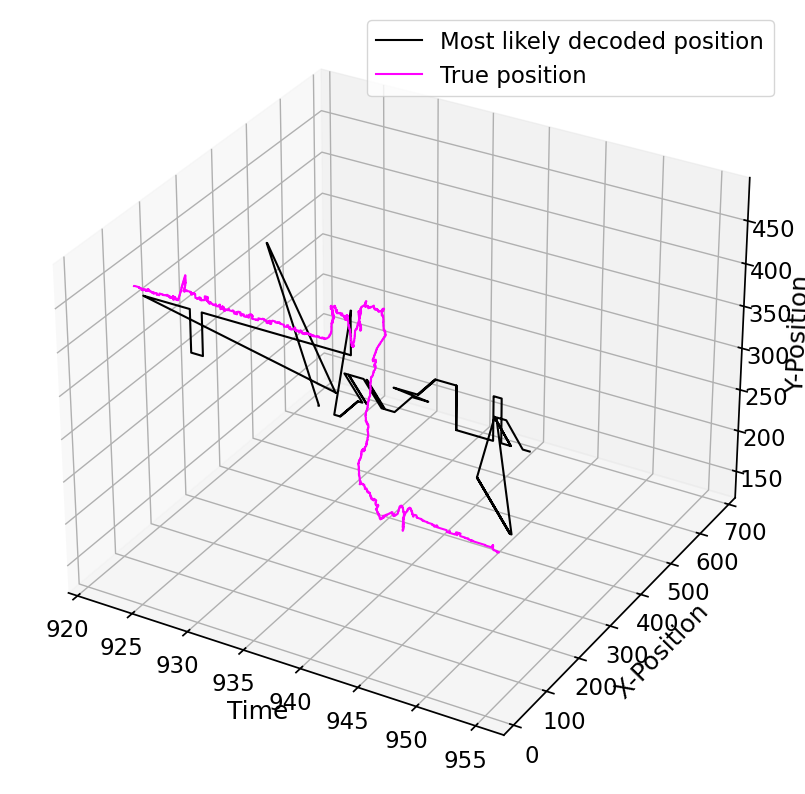

In [35]:
map_estimate = results.causal_posterior.stack(position=['x_position', 'y_position'])
map_estimate = map_estimate.position[map_estimate.argmax('position')]
map_estimate = np.asarray(map_estimate.values.tolist())

plt.figure(figsize=(10, 20))
ax = plt.axes(projection='3d')
ax.plot3D(results.time, map_estimate[:, 0], map_estimate[:, 1], 'black', label='Most likely decoded position')
ax.set_xlabel('Time')
ax.set_ylabel('X-Position')
ax.set_zlabel('Y-Position')

ax.plot3D(results.time, position_test[time_ind, 0], position_test[time_ind, 1], 'magenta', label='True position')
ax.set_xlabel('Time')
ax.set_ylabel('X-Position')
ax.set_zlabel('Y-Position')
plt.legend()
plt.show()

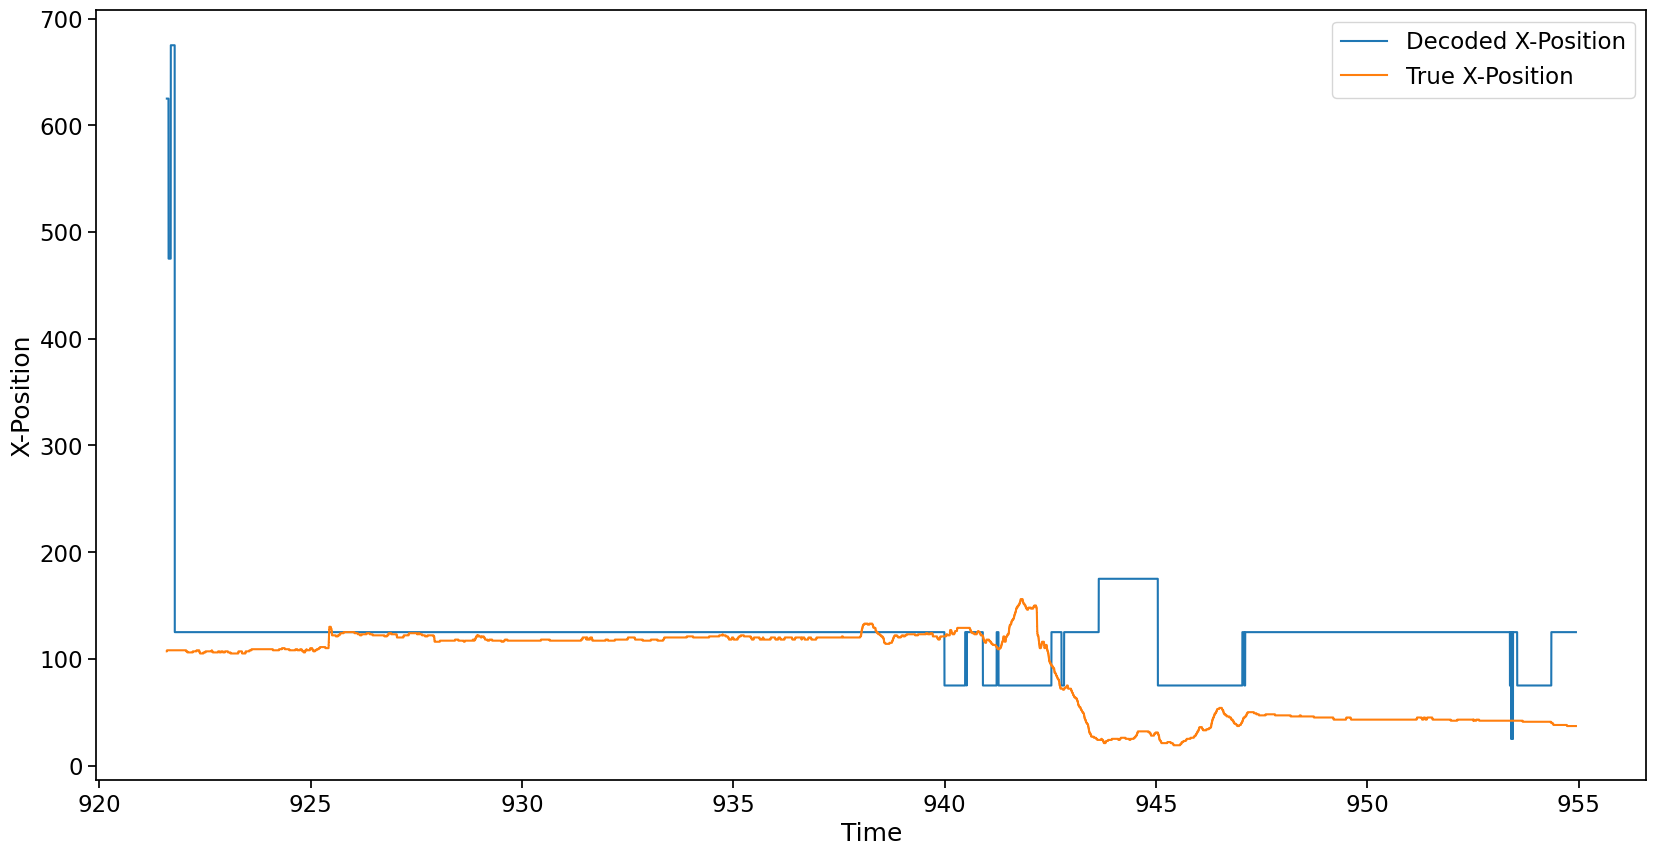

In [36]:
# plotting the x and y seperately
plt.figure(figsize=(20, 10))
plt.plot(results.time, map_estimate[:, 0], label='Decoded X-Position')
plt.plot(results.time, position_test[time_ind, 0], label='True X-Position')
plt.xlabel('Time')
plt.ylabel('X-Position')
plt.legend()
plt.show()


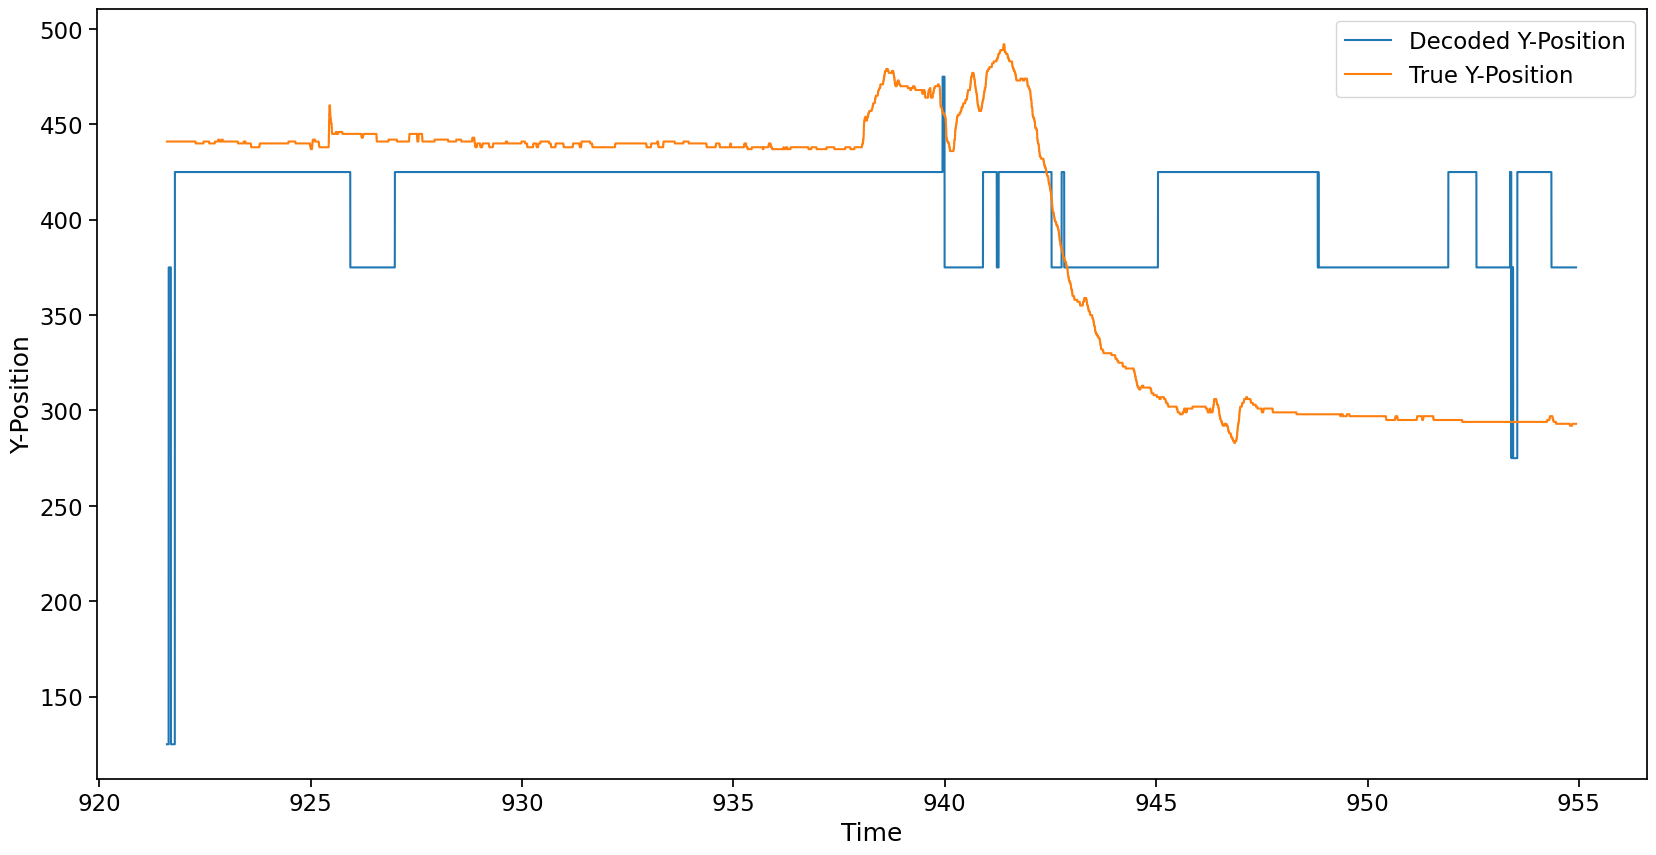

In [37]:
plt.figure(figsize=(20, 10))
plt.plot(results.time, map_estimate[:, 1], label='Decoded Y-Position')
plt.plot(results.time, position_test[time_ind, 1], label='True Y-Position')
plt.xlabel('Time')
plt.ylabel('Y-Position')
plt.legend()
plt.show()